# **SVHN classification using CNN ~ 97.61% (Format 2)**

---



## **1. Imports**

**Mounting Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Importing modules**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import keras
from scipy.io import loadmat
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## **2. Load data**

**Function to load data**

In [3]:
def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

**Change the current working directory**

In [4]:
%cd /content/drive/My Drive/Colab Notebooks/Kaggle/SVHN/

/content/drive/My Drive/Colab Notebooks/Kaggle/SVHN


**Loading data**

In [5]:
X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')
X_extra, y_extra = load_data('extra_32x32.mat')

**Data shapes after loaded**

In [6]:
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Extra training set:", X_extra.shape, y_extra.shape)

Training set: (32, 32, 3, 73257) (73257, 1)
Test set: (32, 32, 3, 26032) (26032, 1)
Extra training set: (32, 32, 3, 531131) (531131, 1)


## **3. Preprocessing**

**Transpose the image arrays**

In [7]:
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]
X_extra, y_extra = X_extra.transpose((3,0,1,2)), y_extra[:,0]

**Add 300000 samples from the extra set to training set**

In [8]:
X_train = np.concatenate((X_train, X_extra[:300000]))
y_train = np.concatenate((y_train, y_extra[:300000]))

**Free some RAM usage**

In [9]:
del X_extra, y_extra

**Data shapes after transposing and merging**

In [10]:
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (373257, 32, 32, 3) (373257,)
Test set: (26032, 32, 32, 3) (26032,)


**Function to plot sample images**

In [11]:
def plot_images(images, labels, num_row=2, num_col=5):

    plt.rcParams['axes.grid'] = False
    fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
    for i in range(num_row * num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap="gray")
        ax.set_title(labels[i],weight='bold',fontsize=20)
    plt.tight_layout()
    
    plt.show()

**Show sample train images**

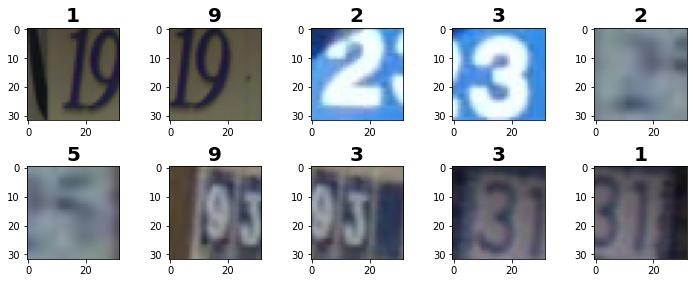

In [12]:
plot_images(X_train, y_train)

**Show sample test images**

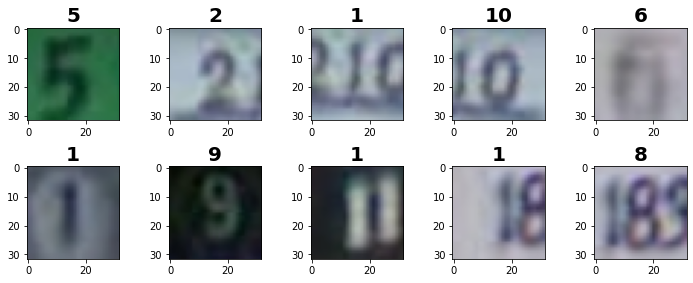

In [13]:
plot_images(X_test, y_test)

**Converting label '10' -> '0'**

In [14]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

**Function to plot distribution of data**

In [15]:
def plot_distribution(y1, y2, title1, title2):

    plt.rcParams['axes.facecolor'] = '#E6E6E6'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['axes.axisbelow'] = True
    plt.rcParams['grid.color'] = 'w'
    plt.rcParams['figure.figsize'] = (12, 4)

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    fig.suptitle('Class Distribution', fontsize=15, fontweight='bold', y=1.05)

    ax1.bar(np.arange(10),np.bincount(y1))
    ax1.set_title(title1)
    ax1.set_xlim(-0.5, 9.5)
    ax1.set_xticks(np.arange(10))
    ax2.bar(np.arange(10),np.bincount(y2),color='coral')
    ax2.set_title(title2)

    fig.tight_layout()

**Plotting class distribution of training set and test set**

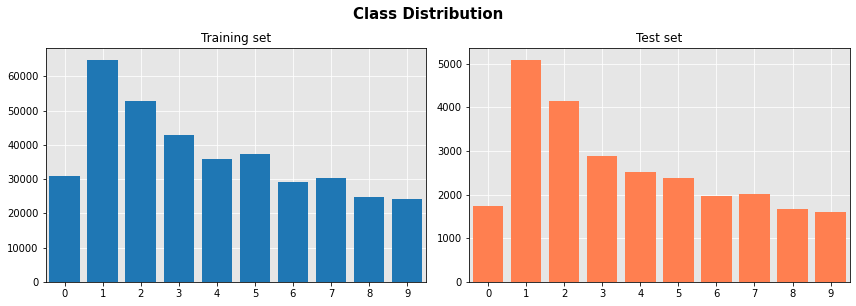

In [16]:
plot_distribution(y_train, y_test, "Training set", "Test set")

**Splitting train set into train and validation set**

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

**Converting label '10' -> '0'**

In [18]:
y_val[y_val == 10] = 0

**Plotting class distribution of training set and validation set**

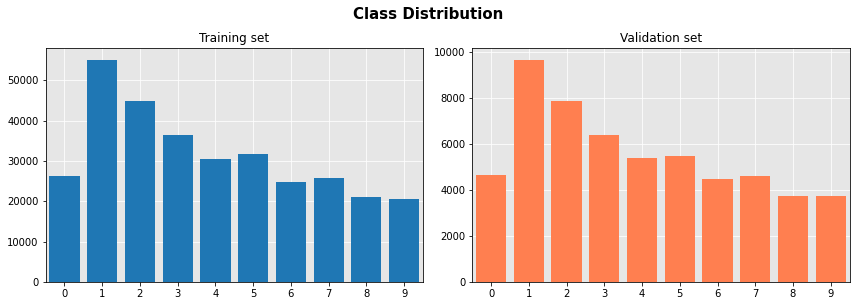

In [19]:
plot_distribution(y_train, y_val, "Training set", "Validation set")

**Turn all images into grayscale**

In [20]:
X_train = rgb2gray(X_train)
X_test = rgb2gray(X_test)
X_val = rgb2gray(X_val)

**Plotting train images after grayscaling**

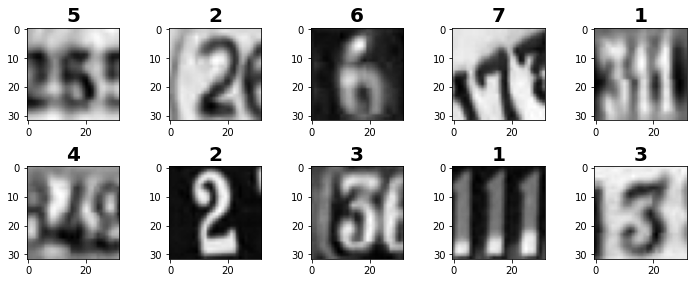

In [21]:
plot_images(X_train, y_train)

**Calculate the mean and the std on the training dataset**

In [22]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

**Normalize images** 

*normalization refers to normalizing the data dimensions so that they are of approximately the same scale. Divide each dimension by its standard deviation, once it has been zero-centered.*
![alt text](https://cs231n.github.io/assets/nn2/prepro1.jpeg)

In [23]:
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean)  / train_std
X_val = (X_val - train_mean) / train_std

**Replot training images to see the difference**

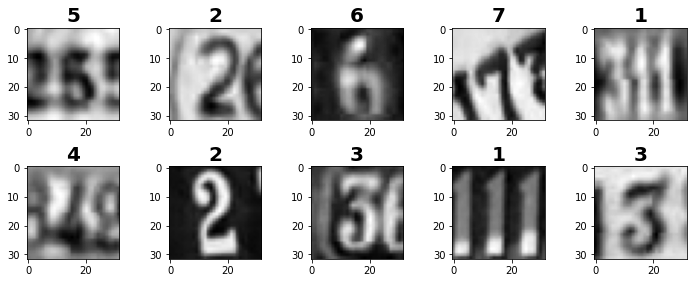

In [24]:
plot_images(X_train, y_train)

**Fit the OneHotEncoder**

In [25]:
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

**Transform the label values to a one-hot-encoding scheme (ready for CNN)**

In [26]:
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()

**Y shapes after OneHotEncoding**

In [27]:
print("Training set", y_train.shape)
print("Validation set", y_val.shape)
print("Test set", y_test.shape)

Training set (317268, 10)
Validation set (55989, 10)
Test set (26032, 10)


**Reshape X from 3 dimensions to 4 dimensions (ready for CNN)**

In [28]:
X_train = X_train.reshape(-1,32,32,1)
X_test = X_test.reshape(-1,32,32,1)
X_val = X_val.reshape(-1,32,32,1)

## **4. Building and training model**

**Define data augmentation**

In [29]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

**Define CNN model**

In [30]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    

    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    

    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Print out model's summary**

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)       

**Fitting model**

In [32]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=256),
                              epochs=50, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
1240/1240 [==============================] - 92s 74ms/step - loss: 0.9753 - accuracy: 0.6542 - val_loss: 0.1670 - val_accuracy: 0.9537
Epoch 2/50
1240/1240 [==============================] - 83s 67ms/step - loss: 0.2077 - accuracy: 0.9441 - val_loss: 0.1178 - val_accuracy: 0.9710
Epoch 3/50
1240/1240 [==============================] - 82s 66ms/step - loss: 0.1615 - accuracy: 0.9564 - val_loss: 0.0996 - val_accuracy: 0.9742
Epoch 4/50
1240/1240 [==============================] - 82s 66ms/step - loss: 0.1419 - accuracy: 0.9621 - val_loss: 0.0999 - val_accuracy: 0.9760
Epoch 5/50
1240/1240 [==============================] - 82s 66ms/step - loss: 0.1318 - accuracy: 0.9651 - val_loss: 0.0925 - val_accuracy: 0.9773
Epoch 6/50
1240/1240 [==============================] - 83s 67ms/step - loss: 0.1234 - accuracy: 0.9672 - val_loss: 0.0913 - val_accuracy: 0.9783
Epoch 7/50
1240/1240 [==============================] - 83s 67ms/step - loss: 0.1172 - accuracy: 0.9691 - val_loss: 0.0831 -

## **5. Visualizations and insights**

**Evaluate train and validation accuracies and losses**

In [33]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

**Visualize epochs vs. train and validation accuracies and losses**

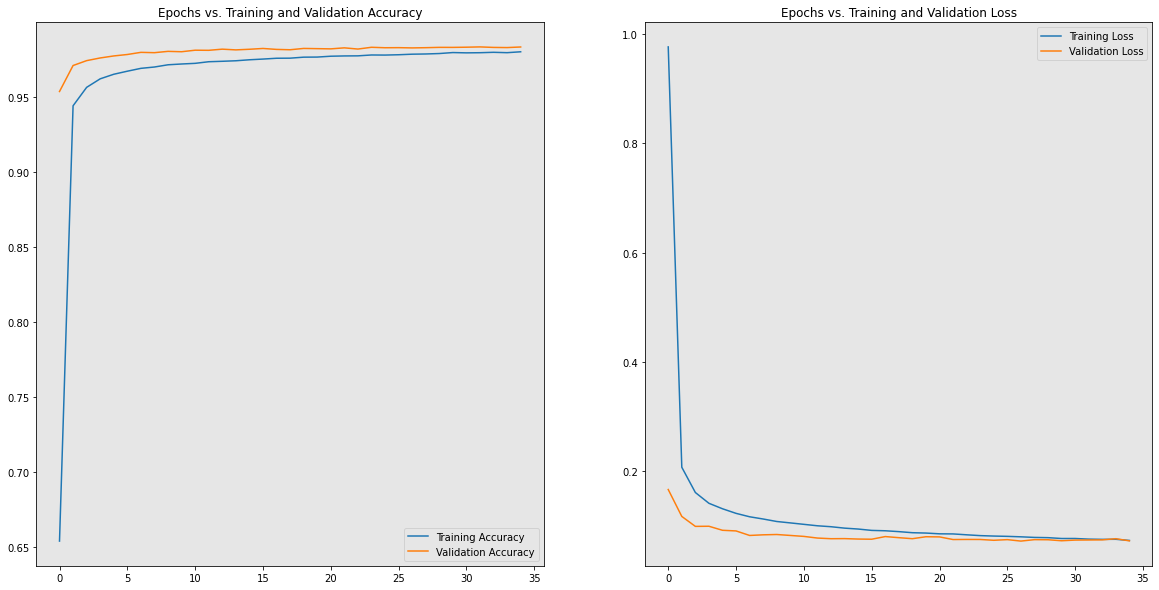

In [34]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

**Evaluate model on test set**

In [35]:
test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9761 
Test loss is: 0.1121


**Get predictions and apply inverse transformation to the labels**

In [36]:
y_pred = model.predict(X_train)

y_pred = enc.inverse_transform(y_pred)
y_train = enc.inverse_transform(y_train)

**Plot the confusion matrix for training set**

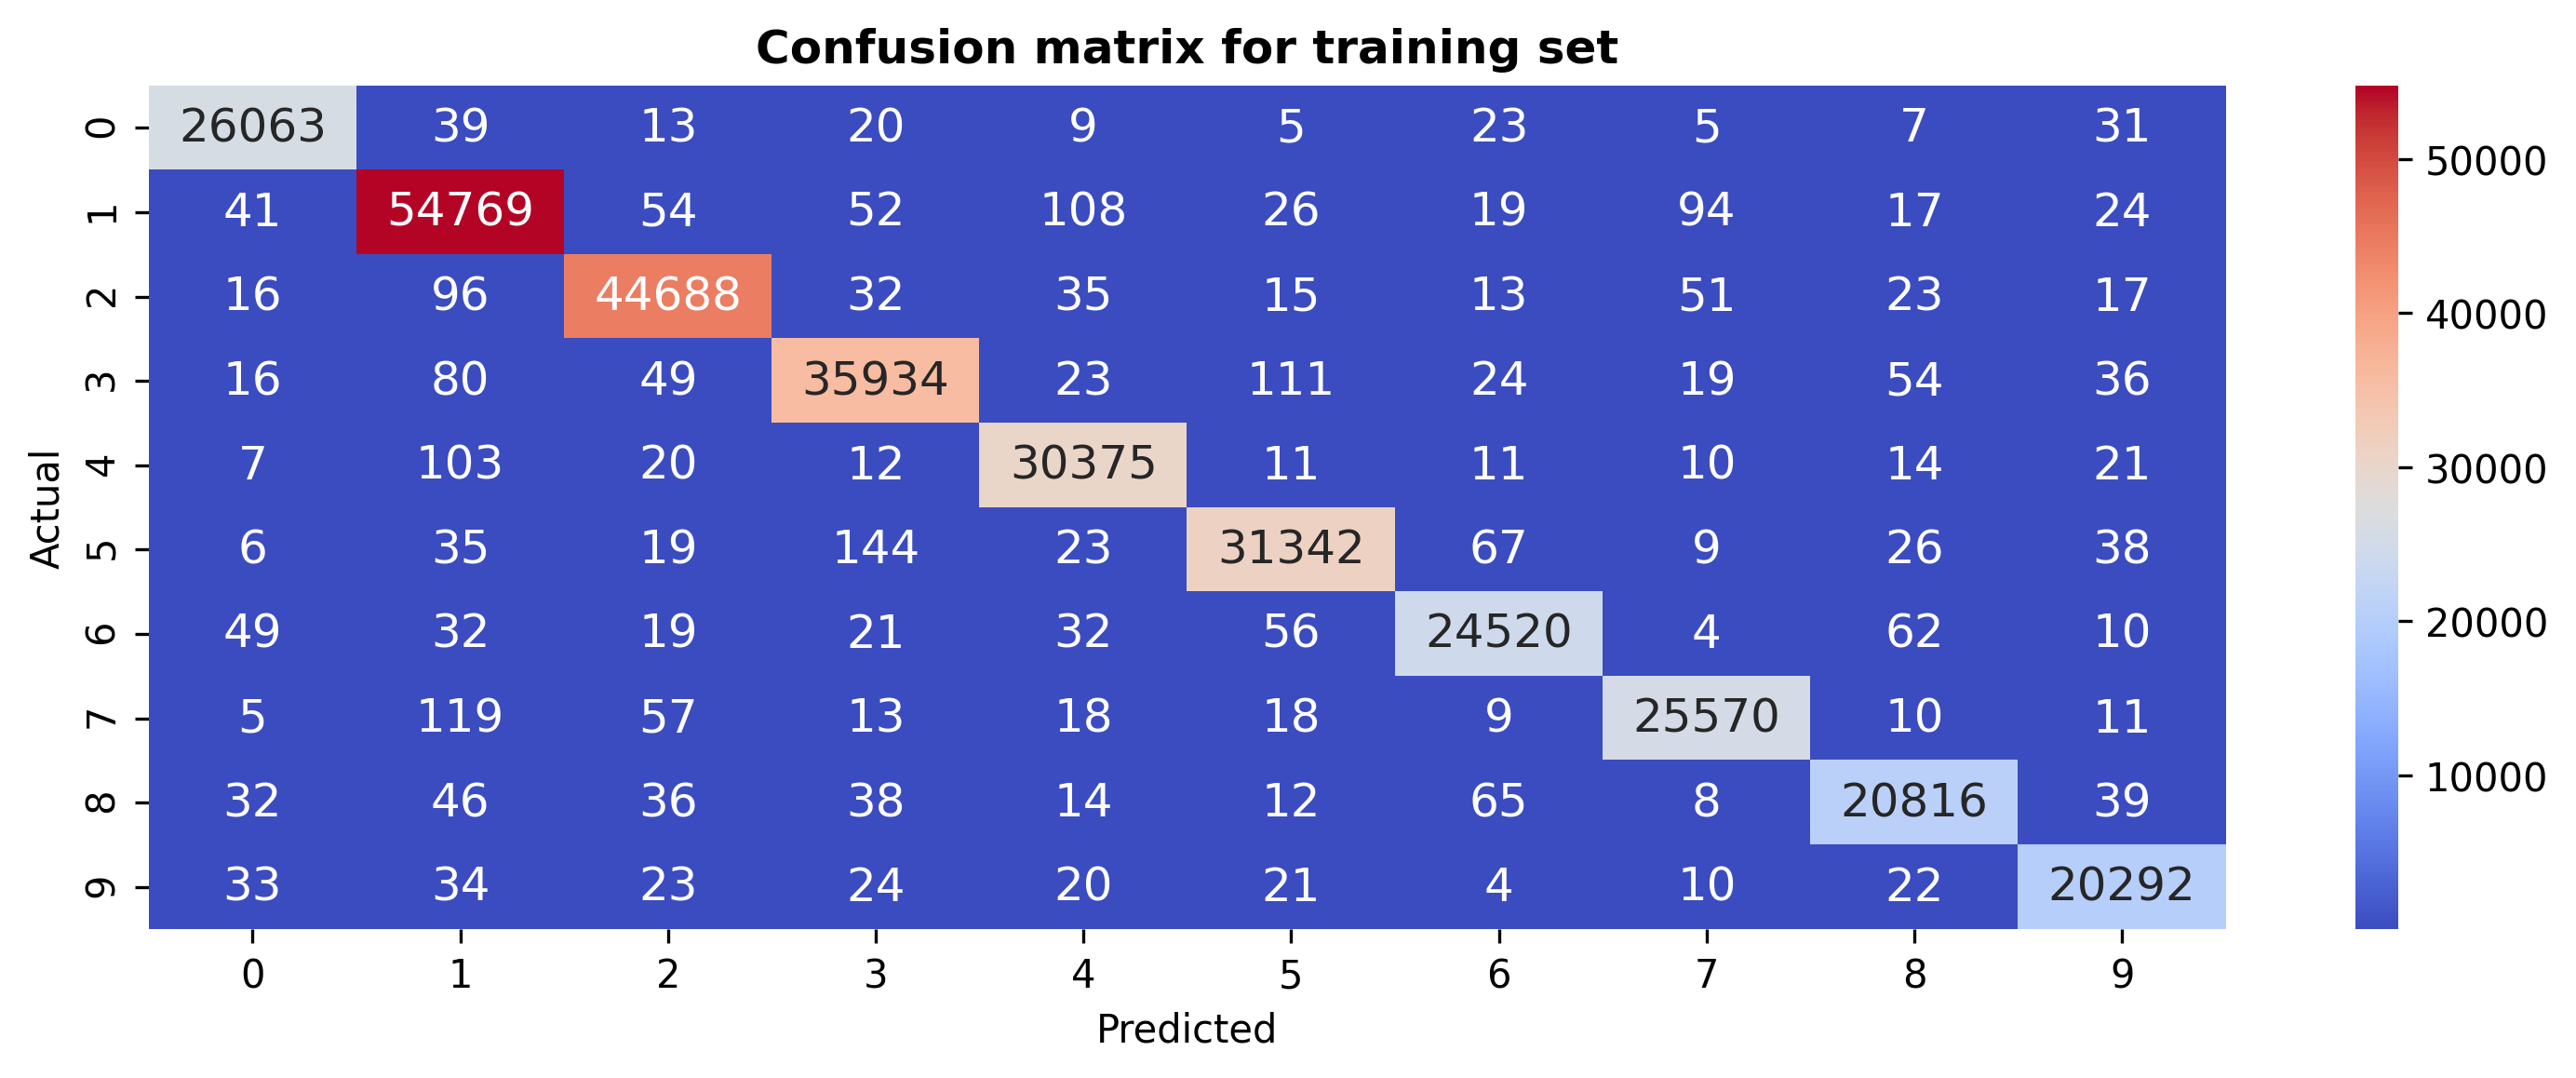

In [37]:
plt.figure(dpi=300)
cm = confusion_matrix(y_train, y_pred)
plt.title('Confusion matrix for training set', weight='bold')
sns.heatmap(cm,annot=True,fmt='g',cmap='coolwarm',annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()